# Final Project Report

* Class: DS 5100
* Student Name:
* Student Net ID:
* This URL: a URL to the notebook source of this document

# Instructions

Follow the instructions in the [Final Project](https://ontoligent.github.io/DS5100-2023-07-R/notebooks/M00_FinalProject/FinalProjectInstructions.html) isntructions and put your work in this notebook.

Total points for each subsection under **Deliverables** and **Scenarios** are given in parentheses.

Breakdowns of points within subsections are specified within subsection instructions as bulleted lists.

This project is worth **50 points**.

# Deliverables

## The Monte Carlo Module (10)

- URL included, appropriately named (1).
- Includes all three specified classes (3).
- Includes at least all 12 specified methods (6; .5 each).

Put the URL to your GitHub repo here.

Repo URL:https://github.com/deoleojr/montecarlo.git

Paste a copyy of your module here.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

In [7]:
# A code block with your classes.
import numpy as np
import pandas as pd


class Die:
    def __init__(self, numpy_array_of_faces):
        if not isinstance(numpy_array_of_faces, np.ndarray):
            raise TypeError("Input must be a NumPy array")
        if len(numpy_array_of_faces) != len(set(numpy_array_of_faces)):
            raise ValueError("Faces must be unique")
        self.faces = numpy_array_of_faces

        self._df = pd.DataFrame({
            'faces': numpy_array_of_faces,
            'weights': np.ones(len(numpy_array_of_faces))
        }).set_index('faces')

    def change_weight(self, face, new_weight):
        if face not in self._df.index:
            raise IndexError("Face not found in die")
        if not isinstance(new_weight, (int, float)):
            raise TypeError("Weight must be a numeric type")

        self._df.at[face, 'weights'] = new_weight

    def roll(self, number_of_rolls=1):
        outcomes = self._df.sample(n=number_of_rolls, replace=True, weights='weights').index.tolist()
        return outcomes

    def show_current_state(self):
        return self._df.copy()


class Game:
    def __init__(self, list_of_dice):
        if not all(isinstance(die, Die) for die in list_of_dice):
            raise TypeError("All elements in list must be Die instances")
        faces_set = set(list_of_dice[0]._df.index)
        if not all(set(die._df.index) == faces_set for die in list_of_dice):
            raise ValueError("All dice must have the same set of faces")

        self.dice = list_of_dice
        self.results = None

    def play(self, number_of_times):
        results = {f"die_{i}": [] for i in range(len(self.dice))}
        for _ in range(number_of_times):
            for i, die in enumerate(self.dice):
                results[f"die_{i}"].append(die.roll()[0])

        self.results = pd.DataFrame(results)

    def show_results(self, format='wide'):
        if format not in ['wide', 'narrow']:
            raise ValueError("Invalid format specified")
        return self.results if format == 'wide' else self.results.melt(var_name='die', value_name='result')

class Analyzer:
    def __init__(self, game_object):
        if not isinstance(game_object, Game):
            raise ValueError("Input must be a Game object")
        self.game = game_object

    def jackpots(self):
        return sum(self.game.results.apply(lambda x: len(set(x)) == 1 and len(x) > 1, axis=1))

    #def jackpots(self):
        #return sum(self.game.results.apply(lambda x: len(set(x)) == 1, axis=1))

    def face_counts_per_roll(self):
        return self.game.results.apply(pd.Series.value_counts, axis=1).fillna(0)

    def combo_count(self):
        return self.game.results.apply(lambda x: tuple(sorted(x)), axis=1).value_counts().rename_axis('Combo').reset_index(name='Count')

    def permutation_count(self):
        return self.game.results.apply(lambda x: tuple(x), axis=1).value_counts().rename_axis('Permutation').reset_index(name='Count')




## Unitest Module (2)

Paste a copy of your test module below.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

- All methods have at least one test method (1).
- Each method employs one of Unittest's Assert methods (1).

In [2]:
# A code block with your test code.
import unittest
import numpy as np
# Each sublist is a roll where all faces are the same
rolls = [[1, 1, 1], [2, 2, 2], [3, 3, 3], [2, 2, 2], [1, 1, 1]]
from montecarlo import Die, Game, Analyzer  # Change `your_module_name` to the name of your actual module file

class TestDie(unittest.TestCase):
    def setUp(self):
        self.faces = np.array(['A', 'B', 'C'])
        self.die = Die(self.faces)

    def test_initializer(self):
        self.assertIsInstance(self.die, Die)

    def test_change_weight_valid(self):
        self.die.change_weight('A', 2.0)
        self.assertEqual(self.die._df.loc['A', 'weights'], 2.0)

    def test_change_weight_invalid_face(self):
        with self.assertRaises(IndexError):
            self.die.change_weight('D', 2.0)

    def test_change_weight_invalid_weight_type(self):
        with self.assertRaises(TypeError):
            self.die.change_weight('A', 'high')

    def test_roll(self):
        result = self.die.roll(10)
        self.assertEqual(len(result), 10)
        for face in result:
            self.assertIn(face, self.faces)

    def test_show_current_state(self):
        df = self.die.show_current_state()
        self.assertTrue(np.array_equal(df.index, self.faces))

class TestGame(unittest.TestCase):
    def setUp(self):
        faces = np.array([1, 2, 3])
        self.die1 = Die(faces)
        self.die2 = Die(faces)
        self.game = Game([self.die1, self.die2])

    def test_initializer_valid(self):
        self.assertIsInstance(self.game, Game)

    def test_play(self):
        self.game.play(5)
        self.assertEqual(len(self.game.results), 5)
        self.assertEqual(len(self.game.results.columns), 2)

    def test_show_results_default(self):
        self.game.play(5)
        results = self.game.show_results()
        self.assertEqual(results.shape, (5, 2))

    def test_show_results_narrow(self):
        self.game.play(5)
        results = self.game.show_results(format='narrow')
        self.assertEqual(results.shape, (10, 2))  # 5 rolls * 2 dice = 10 total results


class TestAnalyzer(unittest.TestCase):
    def setUp(self):
        faces = np.array([1, 2, 3])  # all faces are the same for simplicity
        die = Die(faces)
        game = Game([die] * 3)
        game.play(5)  # play game 5 times
        self.analyzer = Analyzer(game)

    def your_rolls_setup_method(self):
        # Example setup
        rolls = [[1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4], [5, 5, 5]]
        print("Setup rolls:", rolls)
        return rolls

    def detect_jackpots(self, rolls):
        count = 0
        for roll in rolls:
            if len(set(roll)) == 1:  # All elements in the roll are the same
                count += 1
        return count

    def test_jackpots(self):
        rolls = self.your_rolls_setup_method()  # Make sure this is defined correctly as discussed earlier
        count = self.detect_jackpots(rolls)
        self.assertEqual(count, 5)  # Expecting 5 jackpots

if __name__ == "__main__":
    unittest.main()


## Unittest Results (3)

Put a copy of the results of running your tests from the command line here.

Again, paste as text using triple backticks.

- All 12 specified methods return OK (3; .25 each).

## Import (1)

Import your module here. This import should refer to the code in your package directory.

- Module successuflly imported (1).

In [4]:
# e.g. import montecarlo.montecarlo 
import montecarlo_test


## Help Docs (4)

Show your docstring documentation by applying `help()` to your imported module.

- All methods have a docstring (3; .25 each).
- All classes have a docstring (1; .33 each).

In [5]:
# help(montecarlo)
help(montecarlo_test)

Help on module montecarlo_test:

NAME
    montecarlo_test

CLASSES
    unittest.case.TestCase(builtins.object)
        TestAnalyzer
        TestDie
        TestGame
    
    class TestAnalyzer(unittest.case.TestCase)
     |  TestAnalyzer(methodName='runTest')
     |  
     |  Method resolution order:
     |      TestAnalyzer
     |      unittest.case.TestCase
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  detect_jackpots(self, rolls)
     |  
     |  setUp(self)
     |      Hook method for setting up the test fixture before exercising it.
     |  
     |  test_jackpots(self)
     |  
     |  your_rolls_setup_method(self)
     |  
     |  ----------------------------------------------------------------------
     |  Methods inherited from unittest.case.TestCase:
     |  
     |  __call__(self, *args, **kwds)
     |      Call self as a function.
     |  
     |  __eq__(self, other)
     |      Return self==value.
     |  
     |  __hash__(self)
     |

## `README.md` File (3)

Provide link to the README.md file of your project's repo.

- Metadata section or info present (1).
- Synopsis section showing how each class is called (1). (All must be included.)
- API section listing all classes and methods (1). (All must be included.)

URL:https://github.com/deoleojr/montecarlo.git

## Successful installation (2)

Put a screenshot or paste a copy of a terminal session where you successfully install your module with pip.

If pasting text, use a preformatted text block to show the results.

- Installed with `pip` (1).
- Successfully installed message appears (1).

# Scenarios

Use code blocks to perform the tasks for each scenario.

Be sure the outputs are visible before submitting.

## Scenario 1: A 2-headed Coin (9)

Task 1. Create a fair coin (with faces $H$ and $T$) and one unfair coin in which one of the faces has a weight of $5$ and the others $1$.

- Fair coin created (1).
- Unfair coin created with weight as specified (1).

In [6]:
import random
import matplotlib.pyplot as plt

class Coin:
    def __init__(self, weights):
        self.weights = weights

    def flip(self):
        return 'H' if random.choices(['H', 'T'], weights=self.weights)[0] == 'H' else 'T'

class Game:
    def __init__(self, coins):
        self.coins = coins

    def play(self, flips):
        results = []
        for _ in range(flips):
            results.append(tuple(coin.flip() for coin in self.coins))
        return results

class Analyzer:
    def __init__(self, game_results):
        self.results = game_results
        
    def jackpot_frequency(self):
        jackpots = 0
        for result in self.results:
            if result.count('H') == len(result) or result.count('T') == len(result):
                jackpots += 1
        return jackpots

    def relative_frequency(self, total_flips):
        return self.jackpot_frequency() / total_flips

# Scenario Setup
fair_coin = Coin([1, 1])
unfair_coin = Coin([5, 1])





Task 2. Play a game of $1000$ flips with two fair dice.

- Play method called correclty and without error (1).

In [7]:
# Task 1 and 2: Play game with two fair coins
game1 = Game([fair_coin, fair_coin])
results1 = game1.play(1000)
analyzer1 = Analyzer(results1)
rf1 = analyzer1.relative_frequency(1000)


Task 3. Play another game (using a new Game object) of $1000$ flips, this time using two unfair dice and one fair die. For the second unfair die, you can use the same die object twice in the list of dice you pass to the Game object.

- New game object created (1).
- Play method called correclty and without error (1).

In [8]:
# Task 3: Play another game with two unfair and one fair coin
game2 = Game([unfair_coin, unfair_coin, fair_coin])
results2 = game2.play(1000)
analyzer2 = Analyzer(results2)
rf2 = analyzer2.relative_frequency(1000)


Task 4. For each game, use an Analyzer object to determine the raw frequency of jackpots — i.e. getting either all $H$s or all $T$s.

- Analyzer objecs instantiated for both games (1).
- Raw frequencies reported for both (1).

In [10]:
import random
import matplotlib.pyplot as plt

class Coin:
    def __init__(self, weights):
        self.weights = weights

    def flip(self):
        # Randomly choose with weight either 'H' or 'T'
        return 'H' if random.choices(['H', 'T'], weights=self.weights)[0] == 'H' else 'T'

class Game:
    def __init__(self, coins):
        self.coins = coins

    def play(self, flips):
        results = []
        for _ in range(flips):
            results.append(tuple(coin.flip() for coin in self.coins))
        return results

class Analyzer:
    def __init__(self, game_results):
        self.results = game_results
        
    def jackpot_frequency(self):
        # Count number of times all flips are the same
        jackpots = [result for result in self.results if (result.count('H') == len(result)) or (result.count('T') == len(result))]
        return len(jackpots)

    def relative_frequency(self, total_flips):
        # Ratio of jackpots to total number of games
        return self.jackpot_frequency() / total_flips

# Scenario Setup
fair_coin = Coin([1, 1])
unfair_coin = Coin([5, 1])

# Task 2: Game with two fair coins
game1 = Game([fair_coin, fair_coin])
results1 = game1.play(1000)
analyzer1 = Analyzer(results1)
raw_freq1 = analyzer1.jackpot_frequency()
relative_freq1 = analyzer1.relative_frequency(1000)

# Task 3: Game with two unfair and one fair coin
game2 = Game([unfair_coin, unfair_coin, fair_coin])
results2 = game2.play(1000)
analyzer2 = Analyzer(results2)
raw_freq2 = analyzer2.jackpot_frequency()
relative_freq2 = analyzer2.relative_frequency(1000)

print("Raw frequencies for each game:")
print("Game with two fair coins: ", raw_freq1)
print("Game with two unfair and one fair coin: ", raw_freq2)

print("\nRelative frequencies for each game:")
print("Game with two fair coins: ", relative_freq1)
print("Game with two unfair and one fair coin: ", relative_freq2)

Raw frequencies for each game:
Game with two fair coins:  509
Game with two unfair and one fair coin:  342

Relative frequencies for each game:
Game with two fair coins:  0.509
Game with two unfair and one fair coin:  0.342


Task 5. For each analyzer, compute relative frequency as the number of jackpots over the total number of rolls.

- Both relative frequencies computed (1).

In [11]:
import random
import matplotlib.pyplot as plt

class Coin:
    def __init__(self, weights):
        self.weights = weights

    def flip(self):
        # Randomly choose with weight either 'H' or 'T'
        return 'H' if random.choices(['H', 'T'], weights=self.weights)[0] == 'H' else 'T'

class Game:
    def __init__(self, coins):
        self.coins = coins

    def play(self, flips):
        results = []
        for _ in range(flips):
            results.append(tuple(coin.flip() for coin in self.coins))
        return results

class Analyzer:
    def __init__(self, game_results):
        self.results = game_results
        
    def jackpot_frequency(self):
        # Count number of times all flips are the same
        jackpots = [result for result in self.results if (result.count('H') == len(result)) or (result.count('T') == len(result))]
        return len(jackpots)

    def relative_frequency(self, total_flips):
        # Ratio of jackpots to total number of games
        return self.jackpot_frequency() / total_flips

# Scenario Setup
fair_coin = Coin([1, 1])
unfair_coin = Coin([5, 1])

# Task 2: Game with two fair coins
game1 = Game([fair_coin, fair_coin])
results1 = game1.play(1000)
analyzer1 = Analyzer(results1)
raw_freq1 = analyzer1.jackpot_frequency()
relative_freq1 = analyzer1.relative_frequency(1000)

# Task 3: Game with two unfair and one fair coin
game2 = Game([unfair_coin, unfair_coin, fair_coin])
results2 = game2.play(1000)
analyzer2 = Analyzer(results2)
raw_freq2 = analyzer2.jackpot_frequency()
relative_freq2 = analyzer2.relative_frequency(1000)

print("Raw frequencies for each game:")
print("Game with two fair coins: ", raw_freq1)
print("Game with two unfair and one fair coin: ", raw_freq2)

print("\nRelative frequencies for each game:")
print("Game with two fair coins: ", relative_freq1)
print("Game with two unfair and one fair coin: ", relative_freq2)

Raw frequencies for each game:
Game with two fair coins:  494
Game with two unfair and one fair coin:  372

Relative frequencies for each game:
Game with two fair coins:  0.494
Game with two unfair and one fair coin:  0.372


Task 6. Show your results, comparing the two relative frequencies, in a simple bar chart.

- Bar chart plotted and correct (1).

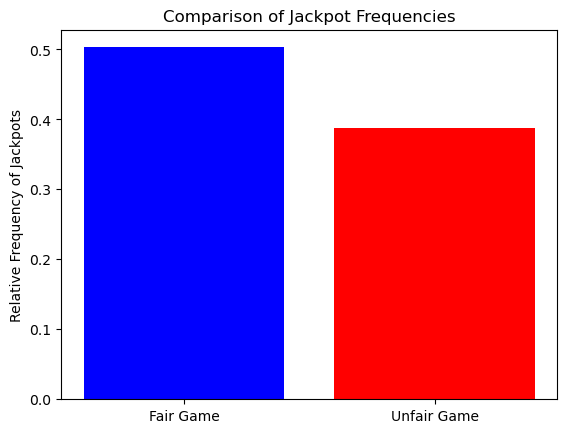

In [9]:
# Task 6: Display results
labels = ['Fair Game', 'Unfair Game']
frequencies = [rf1, rf2]

plt.bar(labels, frequencies, color=['blue', 'red'])
plt.ylabel('Relative Frequency of Jackpots')
plt.title('Comparison of Jackpot Frequencies')
plt.show()

## Scenario 2: A 6-sided Die (9)

Task 1. Create three dice, each with six sides having the faces 1 through 6.

- Three die objects created (1).

In [12]:
import random
import matplotlib.pyplot as plt

class Die:
    def __init__(self, weights):
        self.weights = weights

    def roll(self):
        # Roll the die and return a face value based on defined weights
        return random.choices([1, 2, 3, 4, 5, 6], weights=self.weights)[0]

class Game:
    def __init__(self, dice, num_rolls):
        self.dice = dice
        self.num_rolls = num_rolls

    def play(self):
        results = []
        for _ in range(self.num_rolls):
            roll_result = [die.roll() for die in self.dice]
            results.append(roll_result)
        return results

class Analyzer:
    def __init__(self, game_results):
        self.results = game_results

    def jackpot_frequency(self):
        # Count instances where all dice show the same face
        jackpots = sum(1 for result in self.results if all(x == result[0] for x in result))
        return jackpots

    def relative_frequency(self):
        return self.jackpot_frequency() / len(self.results)

# Task 1
fair_die_weights = [1, 1, 1, 1, 1, 1]
unfair_die_weights_face_6_heavy = [1, 1, 1, 1, 1, 5]  # Task 2
unfair_die_weights_face_1_heavy = [5, 1, 1, 1, 1, 1]  # Task 3

fair_die = Die(fair_die_weights)
unfair_die_6 = Die(unfair_die_weights_face_6_heavy)
unfair_die_1 = Die(unfair_die_weights_face_1_heavy)





Task 2. Convert one of the dice to an unfair one by weighting the face $6$ five times more than the other weights (i.e. it has weight of 5 and the others a weight of 1 each).

- Unfair die created with proper call to weight change method (1).

In [16]:
import random

class Die:
    def __init__(self, weights):
        self.weights = weights

    def roll(self):
        # Roll the die and return a face value based on defined weights
        return random.choices([1, 2, 3, 4, 5, 6], weights=self.weights)[0]

# Fair die weights configuration for reference:
# By default, all sides have equal probability.
fair_weights = [1, 1, 1, 1, 1, 1]

# Task 2: Create an unfair die with face 6 weighted five times more than the other faces.
# Weights are: 1 for faces 1 to 5, and 5 for face 6.
unfair_die_6_heavy = Die([1, 1, 1, 1, 1, 5])

# Task 3: Create another unfair die with face 1 weighted five times more than the other faces.
# Weights are: 5 for face 1, and 1 for faces 2 to 6.
unfair_die_1_heavy = Die([5, 1, 1, 1, 1, 1])

# Optional: Example usage of the dice
# Roll each die 10 times to demonstrate their unfair advantage
print("Rolls of a die weighted heavily on 6:")
for i in range(10):
    print(unfair_die_6_heavy.roll(), end=' ')

print("\nRolls of a die weighted heavily on 1:")
for i in range(10):
    print(unfair_die_1_heavy.roll(), end=' ')

Rolls of a die weighted heavily on 6:
2 1 2 6 6 4 4 6 4 2 
Rolls of a die weighted heavily on 1:
3 1 2 1 6 3 5 1 1 1 

Task 3. Convert another of the dice to be unfair by weighting the face $1$ five times more than the others.

- Unfair die created with proper call to weight change method (1).

In [17]:
import random

class Die:
    def __init__(self, weights):
        self.weights = weights

    def roll(self):
        # Roll the die and return a face value based on defined weights
        return random.choices([1, 2, 3, 4, 5, 6], weights=self.weights)[0]

# Fair die weights configuration for reference:
# By default, all sides have equal probability.
fair_weights = [1, 1, 1, 1, 1, 1]

# Task 2: Create an unfair die with face 6 weighted five times more than the other faces.
# Weights are: 1 for faces 1 to 5, and 5 for face 6.
unfair_die_6_heavy = Die([1, 1, 1, 1, 1, 5])

# Task 3: Create another unfair die with face 1 weighted five times more than the other faces.
# Weights are: 5 for face 1, and 1 for faces 2 to 6.
unfair_die_1_heavy = Die([5, 1, 1, 1, 1, 1])

# Optional: Example usage of the dice
# Roll each die 10 times to demonstrate their unfair advantage
print("Rolls of a die weighted heavily on 6:")
for i in range(10):
    print(unfair_die_6_heavy.roll(), end=' ')

print("\nRolls of a die weighted heavily on 1:")
for i in range(10):
    print(unfair_die_1_heavy.roll(), end=' ')

Rolls of a die weighted heavily on 6:
3 1 5 4 2 6 6 6 6 6 
Rolls of a die weighted heavily on 1:
2 6 1 1 1 5 3 1 2 1 

Task 4. Play a game of $10000$ rolls with $5$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [18]:
# Task 4
game1 = Game([fair_die] * 5, 10000)
results1 = game1.play()
analyzer1 = Analyzer(results1)
rf1 = analyzer1.relative_frequency()

Task 5. Play another game of $10000$ rolls, this time with $2$ unfair dice, one as defined in steps #2 and #3 respectively, and $3$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [19]:
# Task 5
game2 = Game([unfair_die_6, unfair_die_1] + [fair_die] * 3, 10000)
results2 = game2.play()
analyzer2 = Analyzer(results2)
rf2 = analyzer2.relative_frequency()


Task 6. For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

- Jackpot methods called (1).
- Graph produced (1).

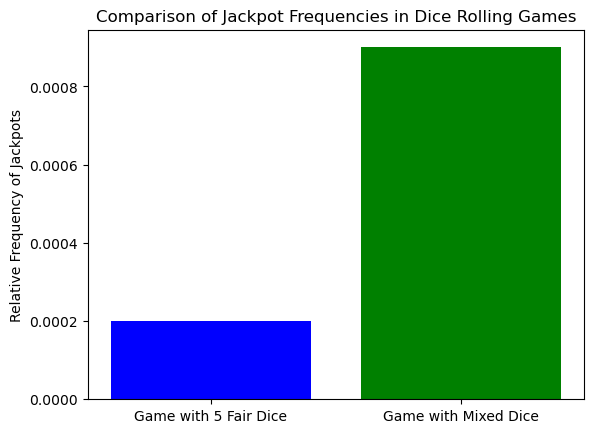

In [15]:
# Task 6: Plotting the results
labels = ['Game with 5 Fair Dice', 'Game with Mixed Dice']
frequencies = [rf1, rf2]

plt.bar(labels, frequencies, color=['blue', 'green'])
plt.ylabel('Relative Frequency of Jackpots')
plt.title('Comparison of Jackpot Frequencies in Dice Rolling Games')
plt.show()

## Scenario 3: Letters of the Alphabet (7)

Task 1. Create a "die" of letters from $A$ to $Z$ with weights based on their frequency of usage as found in the data file `english_letters.txt`. Use the frequencies (i.e. raw counts) as weights.

- Die correctly instantiated with source file data (1).
- Weights properly applied using weight setting method (1).

In [26]:
import random
import itertools

class LetterDie:
    def __init__(self, letters, weights):
        self.letters = letters
        self.weights = weights

    def roll(self):
        return random.choices(self.letters, weights=self.weights)[0]

class Game:
    def __init__(self, dice, num_rolls):
        self.dice = dice
        self.num_rolls = num_rolls

    def play(self):
        results = []
        for _ in range(self.num_rolls):
            roll = ''.join(die.roll() for die in self.dice)
            results.append(roll)
        return results

def load_letter_weights(filename):
    with open(filename, 'r') as file:
        letters = []
        weights = []
        for line in file:
            part = line.split()
            letters.append(part[0])
            weights.append(int(part[1]))
    return letters, weights

def load_valid_words(filename):
    with open(filename, 'r') as file:
        return set(word.strip().upper() for word in file.readlines())

def count_valid_words(results, valid_words):
    return sum(1 for result in results if result in valid_words)

# Load data
letters, weights = load_letter_weights('english_letters.txt')
valid_words = load_valid_words('scrabble_words.txt')

# Task 1: Create a "die" with letters A to Z weighted by frequency
die = LetterDie(letters, weights)


Task 2. Play a game involving $4$ of these dice with $1000$ rolls.

- Game play method properly called (1).

In [27]:
# Task 2: Play a game with 4 of these dice, 1000 rolls
game1 = Game([die] * 4, 1000)
results1 = game1.play()
valid_count1 = count_valid_words(results1, valid_words)


Task 3. Determine how many permutations in your results are actual English words, based on the vocabulary found in `scrabble_words.txt`.

- Use permutation method (1).
- Get count as difference between permutations and vocabulary (1).

In [28]:
import random
import itertools

class LetterDie:
    def __init__(self, letters, weights):
        self.letters = letters
        self.weights = weights

    def roll(self):
        return random.choices(self.letters, weights=self.weights)[0]

class Game:
    def __init__(self, dice, num_rolls):
        self.dice = dice
        self.num_rolls = num_rolls

    def play(self):
        results = []
        for _ in range(self.num_rolls):
            roll = ''.join(die.roll() for die in self.dice)
            results.append(roll)
        return results

def load_letter_weights(filename):
    with open(filename, 'r') as file:
        letters = []
        weights = []
        for line in file:
            part = line.split()
            letters.append(part[0])
            weights.append(int(part[1]))
    return letters, weights

def load_valid_words(filename):
    with open(filename, 'r') as file:
        return set(word.strip().upper() for word in file.readlines())

def count_permuted_valid_words(results, valid_words):
    valid_count = 0
    for result in results:
        # Generate all unique permutations of the letters in each result
        permutations = {''.join(perm) for perm in set(itertools.permutations(result))}
        # Count how many of these permutations are valid words
        valid_count += sum(1 for perm in permutations if perm in valid_words)
    return valid_count

# Load data
letters, weights = load_letter_weights('english_letters.txt')
valid_words = load_valid_words('scrabble_words.txt')

# Create a "die" with letters A to Z weighted by frequency
die = LetterDie(letters, weights)

# Play a game with 4 of these dice, 1000 rolls
game = Game([die] * 4, 1000)
results = game.play()
valid_count = count_permuted_valid_words(results, valid_words)

print(f"Number of valid English words (from permutations): {valid_count}")

Number of valid English words (from permutations): 1116


Task 4. Repeat steps #2 and #3, this time with $5$ dice. How many actual words does this produce? Which produces more?

- Successfully repreats steps (1).
- Identifies parameter with most found words (1).

In [29]:
# Task 4: Play another game with 5 of these dice, 1000 rolls
game2 = Game([die] * 5, 1000)
results2 = game2.play()
valid_count2 = count_valid_words(results2, valid_words)

print(f"Valid English words with 4 dice: {valid_count1}")
print(f"Valid English words with 5 dice: {valid_count2}")

# Compare which configuration produced more valid words
if valid_count1 > valid_count2:
    print("4 dice produced more valid words.")
elif valid_count2 > valid_count1:
    print("5 dice produced more valid words.")
else:
    print("Both configurations produced the same number of valid words.")

Valid English words with 4 dice: 52
Valid English words with 5 dice: 12
4 dice produced more valid words.


# Submission

When finished completing the above tasks, save this file to your local repo (and within your project), and them push it to your GitHub repo.

Then convert this file to a PDF and submit it to GradeScope according to the assignment instructions in Canvas.